In [1]:
import pandas as pd
from matplotlib import pyplot as plt
#!pip install matplotlib
import seaborn as sns

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
lpop = pd.read_stata('ARG_2021_LAPOP_AmericasBarometer_v1.2_w.dta',convert_categoricals=False)
gpt = pd.read_csv('respuestas_gpt35_turbo')
cohere = pd.read_csv('respuestas_cohere.csv')
bard = pd.read_csv('respuestas_bard.csv')

In [3]:
# Crea un StataReader para leer los metadatos
reader = pd.io.stata.StataReader('ARG_2021_LAPOP_AmericasBarometer_v1.2_w.dta')

In [11]:
lpop.columns[0:20]

Index(['idnum', 'uniq_id', 'pais', 'year', 'wave', 'nationality', 'estratopri',
       'strata', 'upm', 'prov1t', 'ur1new', 'q1tb', 'q2', 'wt', 'weight1500',
       'core_a_core_b', 'a4', 'covid2at', 'idio2', 'idio2cov'],
      dtype='object')

In [9]:
reader.value_labels()['edr']

KeyError: 'edr'

In [4]:
import pickle
with open(r"respuestas.pickle", "rb") as input_file:
    respuestas = pickle.load(input_file)
with open(r"preguntas_seleccionadas.pickle", "rb") as input_file:
    preguntas_seleccionadas = pickle.load(input_file)

In [5]:
import math
def calculate_distance(responde,llm):    
    result = 0
    num_pregs = 0
    for pregunta in list(preguntas_seleccionadas.keys()):
        if((pregunta.lower() in responde.keys()) and (not math.isnan(responde[pregunta.lower()])) and (pregunta in list(llm['Pregunta'])) 
           and(llm[llm['Pregunta']== pregunta]['Respuesta'].values[0] < 10) ):
            
            result = result + (abs(responde[pregunta.lower()]-llm[llm['Pregunta']== pregunta]['Respuesta'].values[0]))
            num_pregs = num_pregs + 1
    if(num_pregs == 0):
        result = -1
        norm_result = -1
    else:
        norm_result = result/num_pregs
    
    return(result, num_pregs, norm_result)
calculate_distance(lpop.loc[0],bard)

(31.0, 18, 1.7222222222222223)

In [6]:
lpop['gpt_results'] = lpop.apply(lambda x: calculate_distance(x, gpt), axis=1)
lpop[['gpt_distance', 'gpt_num_preg','gpt_distance_norm']] = pd.DataFrame(lpop['gpt_results'].tolist(), index=lpop.index)

In [7]:
lpop['gpt_num_preg'].value_counts()

gpt_num_preg
1     1434
10     428
9      394
11     289
8      172
0      106
7       85
12      51
6       29
4       11
5        8
3        3
2        1
Name: count, dtype: int64

In [7]:
lpop = lpop.sort_values(by='gpt_distance_norm', ascending=True)

# 2. Calcular el número de filas que representa el 10%
num_rows_10_percent = int(len(lpop) * 0.1)

# 3. Seleccionar las primeras filas correspondientes al 10%
lpop_10_percent = lpop[(lpop['gpt_num_preg']>5)].head(num_rows_10_percent)

In [8]:
lpop_10_percent.shape

(301, 252)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


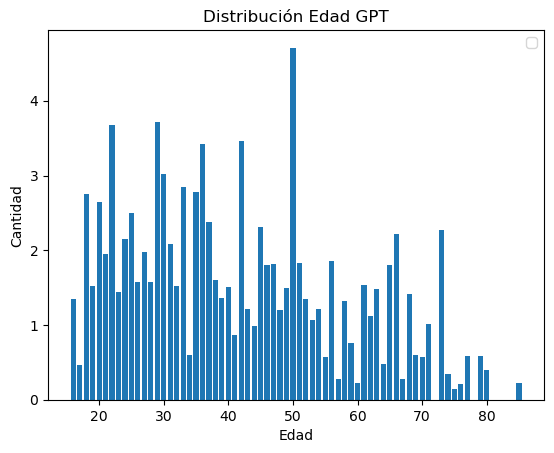

In [16]:
plt.figure(dpi=(100))
# Realiza la suma ponderada por grupo
users_per_grade_gpt = lpop_10_percent.groupby('q2')['wt'].sum()

# Convierte la suma ponderada en porcentajes
users_per_grade_pct = users_per_grade_gpt / users_per_grade_gpt.sum() * 100

# Ordena los valores
users_per_grade_pct_sorted = users_per_grade_pct.sort_values(ascending=False)

plt.bar(users_per_grade_pct_sorted.index, users_per_grade_pct_sorted.values)
plt.title("Distribución Edad GPT")
plt.ylabel("Cantidad")
plt.xlabel("Edad")

plt.legend()
plt.show()



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


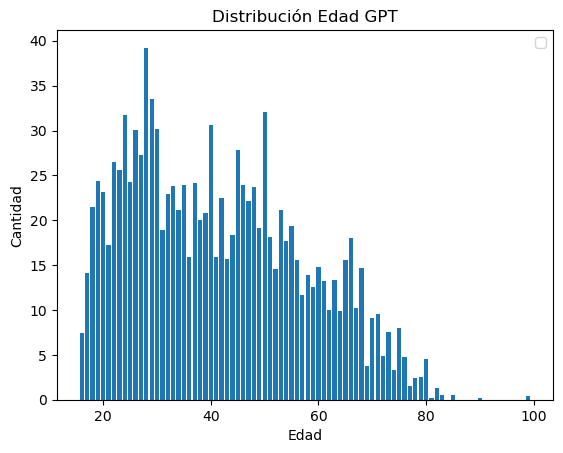

In [17]:
plt.figure(dpi=(100))
# Realiza la suma ponderada por grupo
users_per_grade = lpop.groupby('q2')['wt'].sum()

# Convierte la suma ponderada en porcentajes
users_per_grade_pct = users_per_grade / users_per_grade_gpt.sum() * 100

# Ordena los valores
users_per_grade_pct_sorted = users_per_grade_pct.sort_values(ascending=False)

plt.bar(users_per_grade_pct_sorted.index, users_per_grade_pct_sorted.values)
plt.title("Distribución Edad GPT")
plt.ylabel("Cantidad")
plt.xlabel("Edad")

plt.legend()
plt.show()



In [9]:
from scipy.stats import ttest_ind

# Realizar la prueba 
estadistico, p_valor = ttest_ind((lpop_10_percent['q2'].values), (lpop['q2'].values))

print("Estadístico de prueba t:", estadistico)
print("Valor p:", p_valor)

Estadístico de prueba t: 0.2982514165454384
Valor p: 0.765530001881598


In [18]:
 reader.value_labels()['q1tb_esp']

{1: 'Hombre/masculino', 2: 'Mujer/femenino', 3: 'Otro'}

In [19]:
lpop_10_percent['q1tb_label'] = lpop_10_percent['q1tb'].apply(lambda x: reader.value_labels()['q1tb_esp'][x])

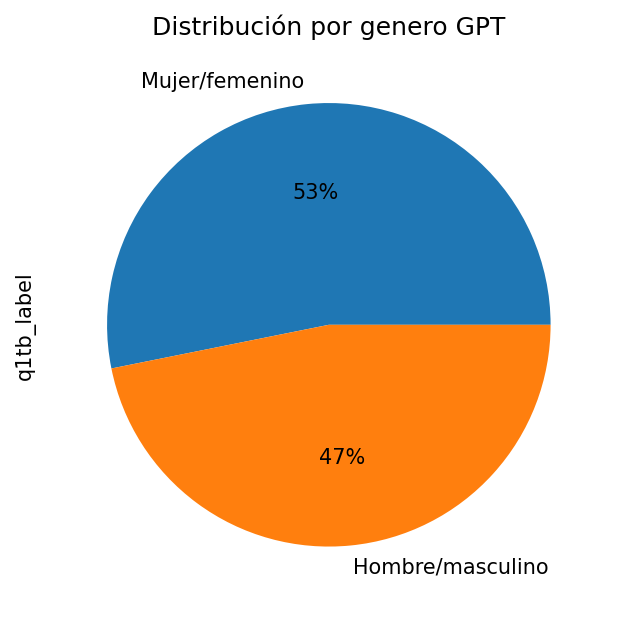

In [20]:
plt.figure(figsize=(6.4, 4.8), dpi=150)
lpop_10_percent['q1tb_label'].value_counts().plot(
    kind='pie', autopct='%1.0f%%'
)
plt.title('Distribución por genero GPT')
plt.savefig('genero GPT.png')
plt.show()

In [21]:
lpop['q1tb_label'] = lpop['q1tb'].apply(lambda x: reader.value_labels()['q1tb_esp'][x])

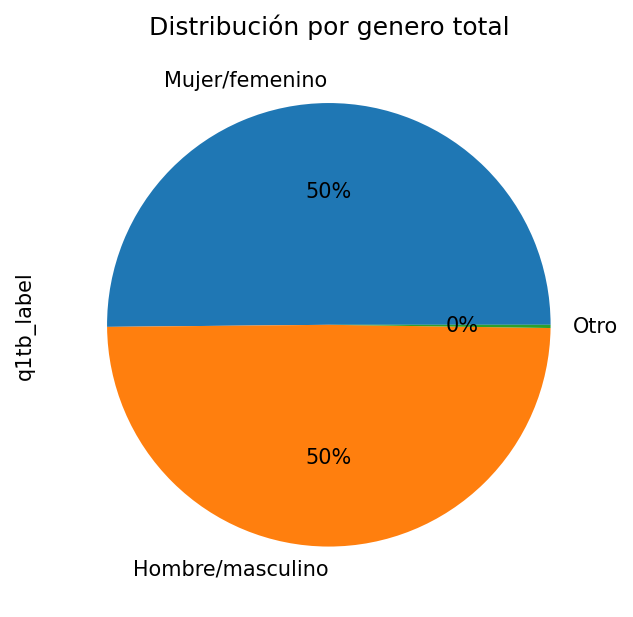

In [22]:
plt.figure(figsize=(6.4, 4.8), dpi=150)
lpop['q1tb_label'].value_counts().plot(
    kind='pie', autopct='%1.0f%%'
)
plt.title('Distribución por genero total')
plt.savefig('genero otal.png')
plt.show()

In [23]:
from statsmodels.stats.proportion import proportions_ztest

# tamaños de las muestras
n_total = lpop.shape[0]# pon aquí el tamaño de la muestra total
n_submuestra = lpop_10_percent.shape[0]# pon aquí el tamaño de la submuestra

# número de éxitos (en este caso, mujeres) en cada muestra
count_total = n_total * 0.50  # 50% de la muestra total son mujeres
count_submuestra = n_submuestra * 0.53  # 55% de la submuestra son mujeres

# realizamos el test de proporciones
z_stat, p_value = proportions_ztest([count_submuestra, count_total], [n_submuestra, n_total])

print('Z-statistic:', z_stat)
print('p-value:', p_value)

Z-statistic: 0.9925472002496668
p-value: 0.3209306665250309


## Provincia

In [24]:
import math
lpop_10_percent['prov1t_label'] = lpop_10_percent['prov1t'].apply(lambda x: None if math.isnan(x) else reader.value_labels()['prov1t_eng'][x])

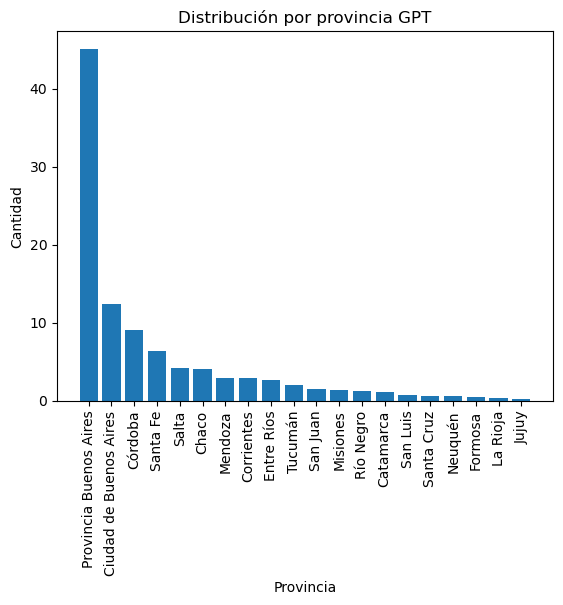

In [25]:
plt.figure(dpi=(100))
# Realiza la suma ponderada por grupo
users_per_grade_gpt = lpop_10_percent.groupby('prov1t_label')['wt'].sum()

# Convierte la suma ponderada en porcentajes
users_per_grade_pct = users_per_grade_gpt / users_per_grade_gpt.sum() * 100

# Ordena los valores
users_per_grade_pct_sorted = users_per_grade_pct.sort_values(ascending=False)

plt.bar(users_per_grade_pct_sorted.index, users_per_grade_pct_sorted.values)
plt.ylabel("Cantidad")
plt.xlabel("Provincia")
plt.title('Distribución por provincia GPT')
plt.xticks(rotation=90)
plt.show()



In [26]:
import math
lpop['prov1t_label'] = lpop['prov1t'].apply(lambda x: None if math.isnan(x) else reader.value_labels()['prov1t_eng'][x])

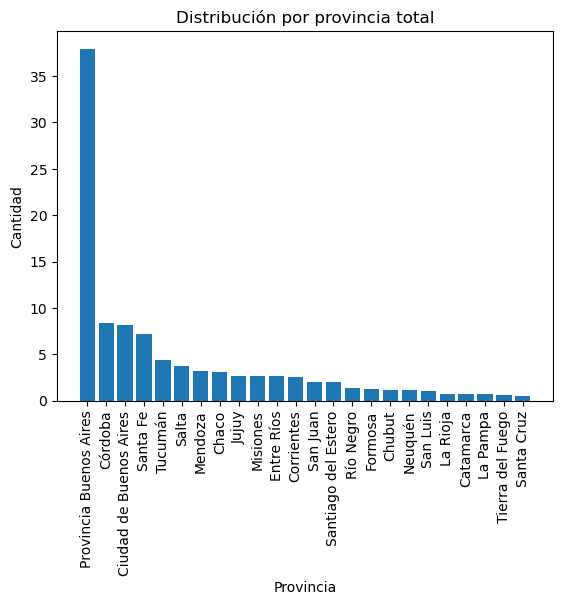

In [27]:
plt.figure(dpi=(100))
# Realiza la suma ponderada por grupo
users_per_grade_total = lpop.groupby('prov1t_label')['wt'].sum()

# Convierte la suma ponderada en porcentajes
users_per_grade_pct = users_per_grade_total / users_per_grade_total.sum() * 100

# Ordena los valores
users_per_grade_pct_sorted = users_per_grade_pct.sort_values(ascending=False)

plt.bar(users_per_grade_pct_sorted.index, users_per_grade_pct_sorted.values)
plt.ylabel("Cantidad")
plt.xlabel("Provincia")
plt.title('Distribución por provincia total')
plt.xticks(rotation=90)
plt.show()



In [30]:
users_per_grade_total.values

array([  22.464758,   93.660385,   36.1954  ,  245.5226  ,   75.98927 ,
        253.37898 ,   78.80069 ,   37.116203,   80.66303 ,   20.269316,
         23.275831,   96.67111 ,   80.493576,   33.160526, 1141.6816  ,
         41.548016,  112.3127  ,   60.34075 ,   32.531673,   16.906616,
        216.05592 ,   59.62294 ,   17.443476,  132.84038 ], dtype=float32)

In [32]:
users_per_grade_gpt.values

array([  3.        ,  10.65483   ,  32.59964   ,   7.488098  ,
        23.759031  ,   7.0304675 ,   1.3753687 ,   0.62536323,
         0.88618225,   7.6609035 ,   3.7558768 ,   1.4420649 ,
       118.27446   ,   3.2065837 ,  10.998275  ,   3.8581674 ,
         1.8774254 ,   1.5889217 ,  16.731884  ,   5.2227225 ],
      dtype=float32)

In [36]:
from scipy.stats import chi2_contingency


# Realizar el test de chi-cuadrado
#chi2, p_valor = chi2_contingency([list(users_per_grade.values), list(users_per_grade_gpt.values)])
contingency_table = [list(users_per_grade_gpt.values), list(users_per_grade_total.values)]

chi2, p_value, _, _ = chi2_contingency(contingency_table)

print("Estadístico de chi-cuadrado:", chi2)
print("Valor p:", p_valor)

TypeError: '<' not supported between instances of 'list' and 'int'

## Urbanización

In [37]:

lpop_10_percent['ur1new_label'] = lpop_10_percent['ur1new'].apply(lambda x: None if math.isnan(x) else reader.value_labels()['ur1new_esp'][x])
lpop['ur1new_label'] = lpop['ur1new'].apply(lambda x: None if math.isnan(x) else reader.value_labels()['ur1new_esp'][x])

In [41]:
lpop_10_percent.shape

(301, 255)

In [42]:
lpop.shape

(3011, 255)

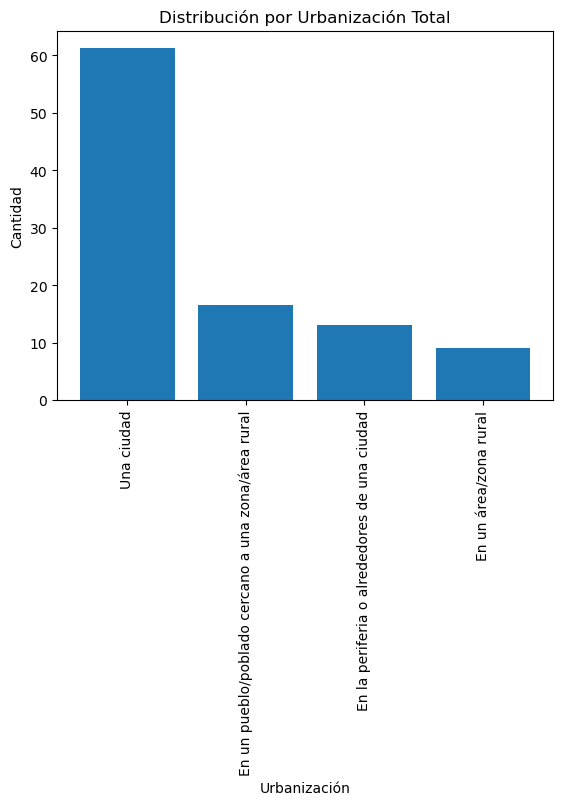

In [38]:
plt.figure(dpi=(100))
# Realiza la suma ponderada por grupo
users_per_grade_total = lpop.groupby('ur1new_label')['wt'].sum()

# Convierte la suma ponderada en porcentajes
users_per_grade_pct = users_per_grade_total / users_per_grade_total.sum() * 100

# Ordena los valores
users_per_grade_pct_sorted = users_per_grade_pct.sort_values(ascending=False)

plt.bar(users_per_grade_pct_sorted.index, users_per_grade_pct_sorted.values)
plt.ylabel("Cantidad")
plt.xlabel("Urbanización")
plt.title('Distribución por Urbanización Total')
plt.xticks(rotation=90)
plt.show()


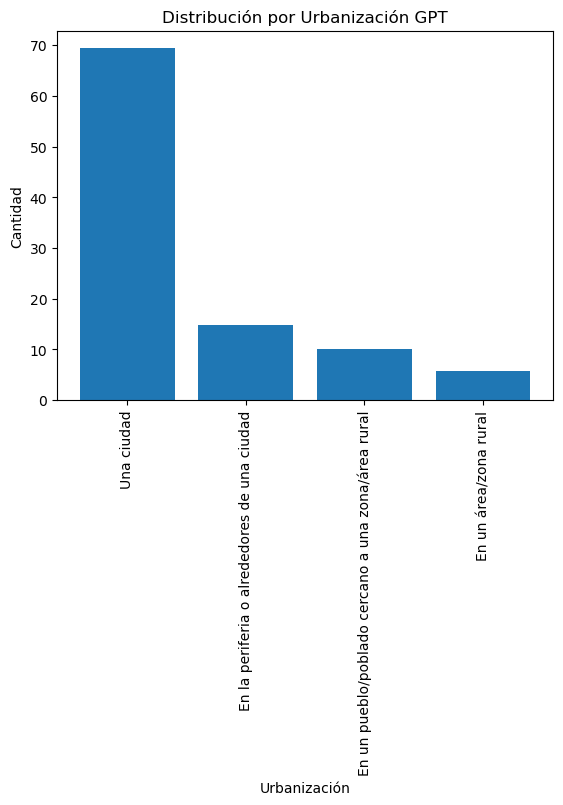

In [39]:
plt.figure(dpi=(100))
# Realiza la suma ponderada por grupo
users_per_grade_gpt = lpop_10_percent.groupby('ur1new_label')['wt'].sum()

# Convierte la suma ponderada en porcentajes
users_per_grade_pct = users_per_grade_gpt / users_per_grade_gpt.sum() * 100

# Ordena los valores
users_per_grade_pct_sorted = users_per_grade_pct.sort_values(ascending=False)

plt.bar(users_per_grade_pct_sorted.index, users_per_grade_pct_sorted.values)
plt.ylabel("Cantidad")
plt.xlabel("Urbanización")
plt.title('Distribución por Urbanización GPT')
plt.xticks(rotation=90)
plt.show()


In [40]:
from scipy.stats import chi2_contingency


# Realizar el test de chi-cuadrado
#chi2, p_valor = chi2_contingency([list(users_per_grade.values), list(users_per_grade_gpt.values)])
chi2, p_valor, _, _ = chi2_contingency([list(users_per_grade_gpt.values), list(users_per_grade_total.values)])

print("Estadístico de chi-cuadrado:", chi2)
print("Valor p:", p_valor)

Estadístico de chi-cuadrado: 12.689772820065036
Valor p: 0.005357859523589695


## Nivel educativo

In [10]:

lpop_10_percent['edr_label'] = lpop_10_percent['edr'].apply(lambda x: None if math.isnan(x) else reader.value_labels()['edr_esp'][x])

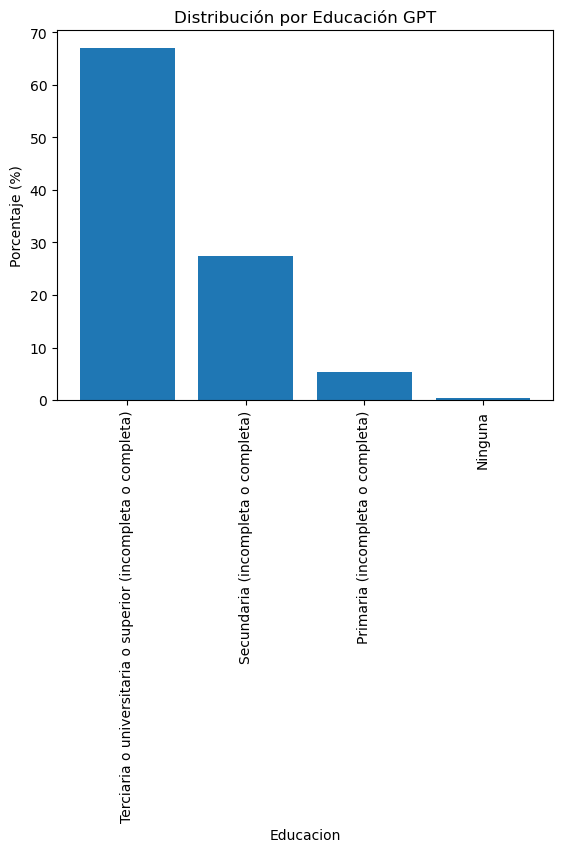

In [21]:
plt.figure(dpi=(100))
# Realiza la suma ponderada por grupo
users_per_grade_gpt = lpop_10_percent['edr_label'].value_counts()

# Convierte la suma ponderada en porcentajes
users_per_grade_pct = users_per_grade_gpt / users_per_grade_gpt.sum() * 100

# Ordena los valores
users_per_grade_pct_sorted = users_per_grade_pct.sort_values(ascending=False)

plt.bar(users_per_grade_pct_sorted.index, users_per_grade_pct_sorted.values)
plt.ylabel("Porcentaje (%)")
plt.xlabel("Educacion")
plt.title('Distribución por Educación GPT')
plt.xticks(rotation=90)
plt.show()

In [22]:
users_per_grade_pct_sorted

Terciaria o universitaria o superior (incompleta o completa)    67.000000
Secundaria (incompleta o completa)                              27.333333
Primaria (incompleta o completa)                                 5.333333
Ninguna                                                          0.333333
Name: edr_label, dtype: float64

In [20]:
users_per_grade_pct_sorted_total

Terciaria o universitaria o superior (incompleta o completa)    48.936877
Secundaria (incompleta o completa)                              37.641196
Primaria (incompleta o completa)                                12.657807
Ninguna                                                          0.764120
Name: edr_label, dtype: float64

In [14]:
lpop['edr_label'] = lpop['edr'].apply(lambda x: None if math.isnan(x) else reader.value_labels()['edr_esp'][x])

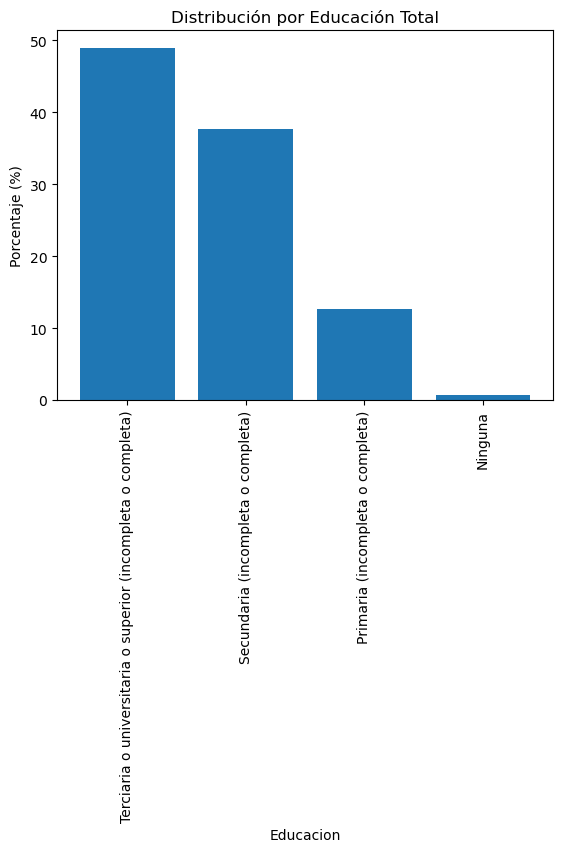

In [19]:
plt.figure(dpi=(100))
# Realiza la suma ponderada por grupo
users_per_grade = lpop['edr_label'].value_counts()

# Convierte la suma ponderada en porcentajes
users_per_grade_pct = users_per_grade / users_per_grade.sum() * 100

# Ordena los valores
users_per_grade_pct_sorted_total = users_per_grade_pct.sort_values(ascending=False)

plt.bar(users_per_grade_pct_sorted_total.index, users_per_grade_pct_sorted_total.values)
plt.ylabel("Porcentaje (%)")
plt.xlabel("Educacion")
plt.title('Distribución por Educación Total')
plt.xticks(rotation=90)
plt.show()

In [23]:
from scipy.stats import chi2_contingency

# Realizar el test de chi-cuadrado
#chi2, p_valor = chi2_contingency([list(users_per_grade.values), list(users_per_grade_gpt.values)])
chi2, p_valor, _, _ = chi2_contingency([list(users_per_grade.values), list(users_per_grade_gpt.values)])

print("Estadístico de chi-cuadrado:", chi2)
print("Valor p:", p_valor)

Estadístico de chi-cuadrado: 38.397740456674875
Valor p: 2.328240939218549e-08


## Ingresos

In [51]:
lpop_10_percent['q10newt_label'] = lpop_10_percent['q10newt'].apply(lambda x: None if math.isnan(x) else reader.value_labels()['q10newt_esp'][x])

In [9]:
lpop_10_percent['q10newt'].isnull().sum()/lpop_10_percent.shape[0]

1.0

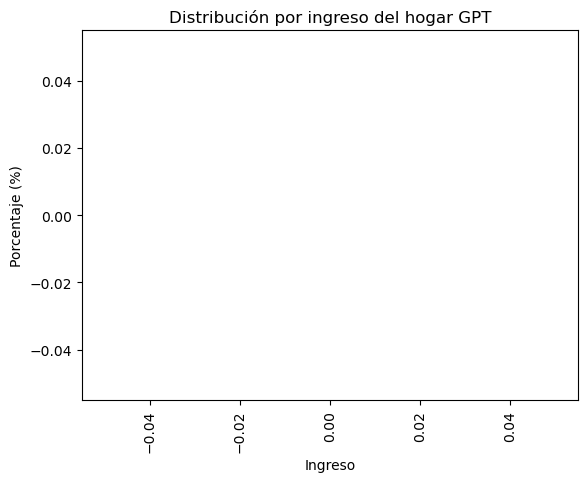

In [52]:
plt.figure(dpi=(100))
# Realiza la suma ponderada por grupo
users_per_grade = lpop_10_percent.groupby('q10newt_label')['wt'].sum()

# Convierte la suma ponderada en porcentajes
users_per_grade_pct = users_per_grade / users_per_grade.sum() * 100

# Ordena los valores
users_per_grade_pct_sorted = users_per_grade_pct.sort_values(ascending=False)

plt.bar(users_per_grade_pct_sorted.index, users_per_grade_pct_sorted.values)
plt.ylabel("Porcentaje (%)")
plt.xlabel("Ingreso")
plt.title('Distribución por ingreso del hogar GPT')
plt.xticks(rotation=90)
plt.show()

In [73]:
users_per_grade_pct_sorted

Series([], Name: wt, dtype: float32)

In [74]:
lpop['q10newt_label'] = lpop['q10newt'].apply(lambda x: None if math.isnan(x) else reader.value_labels()['q10newt_esp'][x])

C:\Users\PC-Usuario\AppData\Local\Temp\ipykernel_4924\3273679197.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  lpop['q10newt_label'] = lpop['q10newt'].apply(lambda x: None if math.isnan(x) else reader.value_labels()['q10newt_esp'][x])


In [78]:
users_per_grade

Series([], Name: wt, dtype: float32)

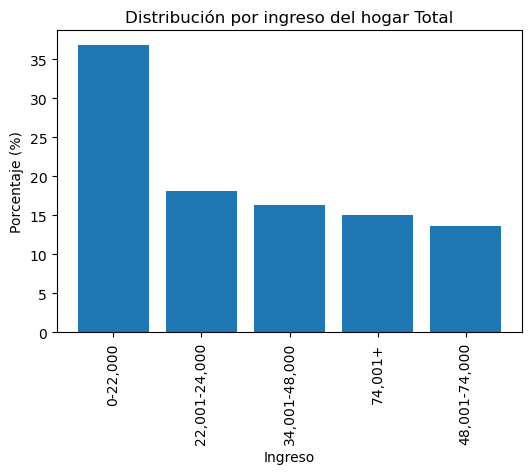

In [76]:
plt.figure(dpi=(100))
# Realiza la suma ponderada por grupo
users_per_grade_total = lpop.groupby('q10newt_label')['wt'].sum()

# Convierte la suma ponderada en porcentajes
users_per_grade_pct = users_per_grade_total / users_per_grade_total.sum() * 100

# Ordena los valores
users_per_grade_pct_sorted = users_per_grade_pct.sort_values(ascending=False)

plt.bar(users_per_grade_pct_sorted.index, users_per_grade_pct_sorted.values)
plt.ylabel("Porcentaje (%)")
plt.xlabel("Ingreso")
plt.title('Distribución por ingreso del hogar Total')
plt.xticks(rotation=90)
plt.show()

In [77]:
from scipy.stats import chi2_contingency

# Realizar el test de chi-cuadrado
#chi2, p_valor = chi2_contingency([list(users_per_grade.values), list(users_per_grade_gpt.values)])
chi2, p_valor, _, _ = chi2_contingency([ list(users_per_grade_total.values),list(users_per_grade.values)])

print("Estadístico de chi-cuadrado:", chi2)
print("Valor p:", p_valor)

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (2,) + inhomogeneous part.

## Conocimiento de política

In [24]:
lpop_10_percent['conocim_label'] = lpop_10_percent['conocim'].apply(lambda x: None if math.isnan(x) else reader.value_labels()['conocim_esp'][x])

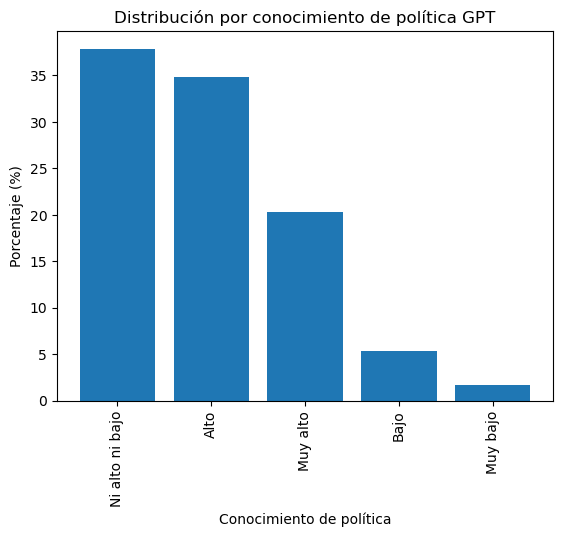

In [30]:
plt.figure(dpi=(100))
# Realiza la suma ponderada por grupo
users_per_grade = lpop_10_percent['conocim_label'].value_counts()
# Convierte la suma ponderada en porcentajes
users_per_grade_pct = users_per_grade / users_per_grade.sum() * 100

# Ordena los valores
users_per_grade_pct_sorted = users_per_grade_pct.sort_values(ascending=False)

plt.bar(users_per_grade_pct_sorted.index, users_per_grade_pct_sorted.values)
plt.ylabel("Porcentaje (%)")
plt.xlabel("Conocimiento de política")
plt.title('Distribución por conocimiento de política GPT')
plt.xticks(rotation=90)
plt.show()

In [31]:
users_per_grade_pct_sorted

Ni alto ni bajo    37.873754
Alto               34.883721
Muy alto           20.265781
Bajo                5.315615
Muy bajo            1.661130
Name: conocim_label, dtype: float64

In [26]:
lpop['conocim_label'] = lpop['conocim'].apply(lambda x: None if math.isnan(x) else reader.value_labels()['conocim_esp'][x])

In [29]:
users_per_grade_pct_sorted

Ni alto ni bajo    43.772833
Alto               32.015942
Muy alto           13.251411
Bajo                9.199601
Muy bajo            1.760213
Name: conocim_label, dtype: float64

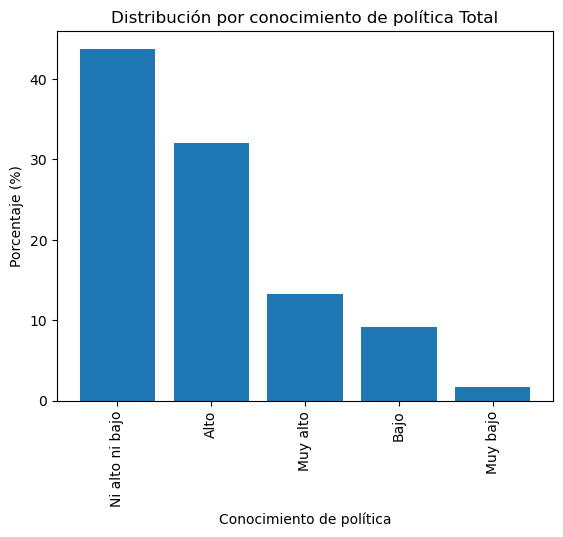

In [27]:
plt.figure(dpi=(100))
# Realiza la suma ponderada por grupo
users_per_grade_total = lpop['conocim_label'].value_counts()

# Convierte la suma ponderada en porcentajes
users_per_grade_pct = users_per_grade_total / users_per_grade_total.sum() * 100

# Ordena los valores
users_per_grade_pct_sorted = users_per_grade_pct.sort_values(ascending=False)

plt.bar(users_per_grade_pct_sorted.index, users_per_grade_pct_sorted.values)
plt.ylabel("Porcentaje (%)")
plt.xlabel("Conocimiento de política")
plt.title('Distribución por conocimiento de política Total')
plt.xticks(rotation=90)
plt.show()

In [32]:
from scipy.stats import chi2_contingency

# Realizar el test de chi-cuadrado
#chi2, p_valor = chi2_contingency([list(users_per_grade.values), list(users_per_grade_gpt.values)])
chi2, p_valor, _, _ = chi2_contingency([ list(users_per_grade_total.values),list(users_per_grade.values)])

print("Estadístico de chi-cuadrado:", chi2)
print("Valor p:", p_valor)

Estadístico de chi-cuadrado: 17.27510482559344
Valor p: 0.0017089344429050423


In [92]:
reader.value_labels()['conocim_esp']

{1: 'Muy alto', 2: 'Alto', 3: 'Ni alto ni bajo', 4: 'Bajo', 5: 'Muy bajo'}

## Etnicidad

In [61]:
lpop_10_percent['etid_label'] = lpop_10_percent['etid'].apply(lambda x: None if math.isnan(x) else reader.value_labels()['etid_esp'][x])
lpop['etid_label'] = lpop['etid'].apply(lambda x: None if math.isnan(x) else reader.value_labels()['etid_esp'][x])

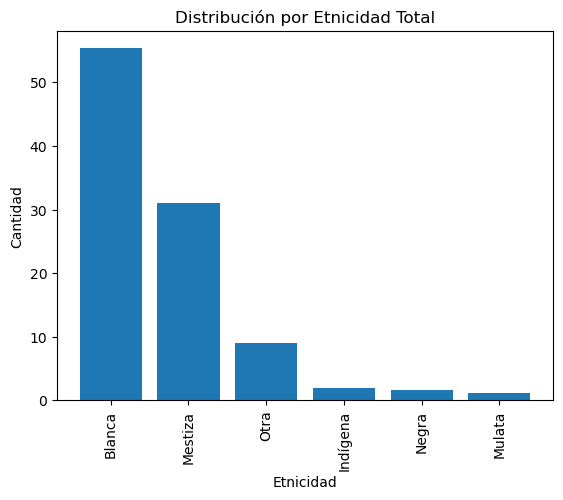

In [62]:
plt.figure(dpi=(100))
# Realiza la suma ponderada por grupo
users_per_grade_total = lpop.groupby('etid_label')['wt'].sum()

# Convierte la suma ponderada en porcentajes
users_per_grade_pct = users_per_grade_total / users_per_grade_total.sum() * 100

# Ordena los valores
users_per_grade_pct_sorted = users_per_grade_pct.sort_values(ascending=False)

plt.bar(users_per_grade_pct_sorted.index, users_per_grade_pct_sorted.values)
plt.ylabel("Cantidad")
plt.xlabel("Etnicidad")
plt.title('Distribución por Etnicidad Total')
plt.xticks(rotation=90)
plt.show()


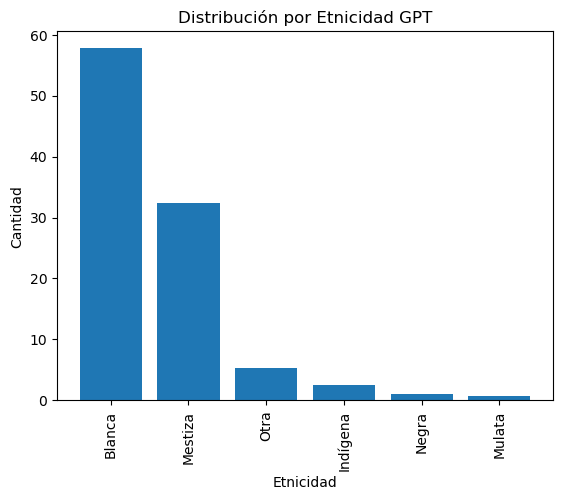

In [63]:
plt.figure(dpi=(100))
# Realiza la suma ponderada por grupo
users_per_grade_gpt = lpop_10_percent.groupby('etid_label')['wt'].sum()

# Convierte la suma ponderada en porcentajes
users_per_grade_pct_gpt = users_per_grade_gpt / users_per_grade_gpt.sum() * 100

# Ordena los valores
users_per_grade_pct_sorted = users_per_grade_pct_gpt.sort_values(ascending=False)

plt.bar(users_per_grade_pct_sorted.index, users_per_grade_pct_sorted.values)
plt.ylabel("Cantidad")
plt.xlabel("Etnicidad")
plt.title('Distribución por Etnicidad GPT')
plt.xticks(rotation=90)
plt.show()


In [64]:
from scipy.stats import chi2_contingency

# Realizar el test de chi-cuadrado
#chi2, p_valor = chi2_contingency([list(users_per_grade.values), list(users_per_grade_gpt.values)])
chi2, p_valor, _, _ = chi2_contingency([ list(users_per_grade_total.values),list(users_per_grade_gpt.values)])

print("Estadístico de chi-cuadrado:", chi2)
print("Valor p:", p_valor)

Estadístico de chi-cuadrado: 4.977788641749566
Valor p: 0.4185969112759086


## Diferencias significativas entre quienes opinaron como GPT y el total


- Nivel educativo: GPT es mas educado
- Conocimiento de politica: GPT esta mas politizado

## No se diferencian en:

- Etnicidad
- Nivel de ingreso (no pude medirlo)
- Urbanizacion
- Provincia
- Genero
- Edad

In [35]:
lpop['gpt_distance_norm_wt'] =  lpop['gpt_distance_norm'] * lpop['wt']

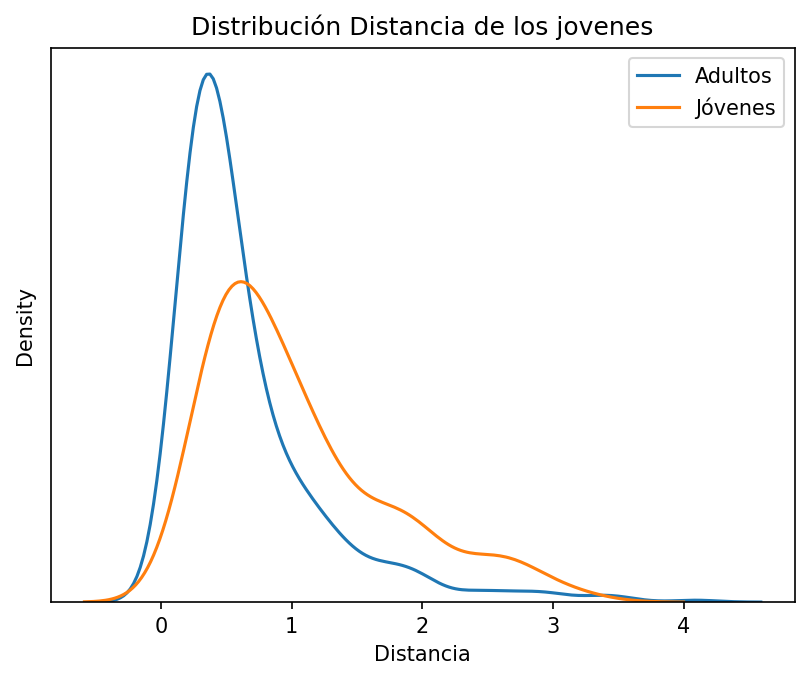

In [36]:
lpop_adulto = lpop[lpop['q2']>40]
lpop_joven = lpop[lpop['q2']<25]
plt.figure(dpi=150)

sns.kdeplot(
   lpop_adulto[lpop_adulto['gpt_num_preg']>8]['gpt_distance_norm_wt'], label="Adultos"
)
sns.kdeplot(
   lpop_joven[lpop_joven['gpt_num_preg']>8]['gpt_distance_norm_wt'], label="Jóvenes"
)
plt.title("Distribución Distancia de los jovenes")
plt.xlabel("Distancia")
plt.yticks([], [])
plt.legend(loc='upper right')
plt.show()

In [ ]:
lpop_10_percent = lpop[(lpop['gpt_num_preg']>5)]

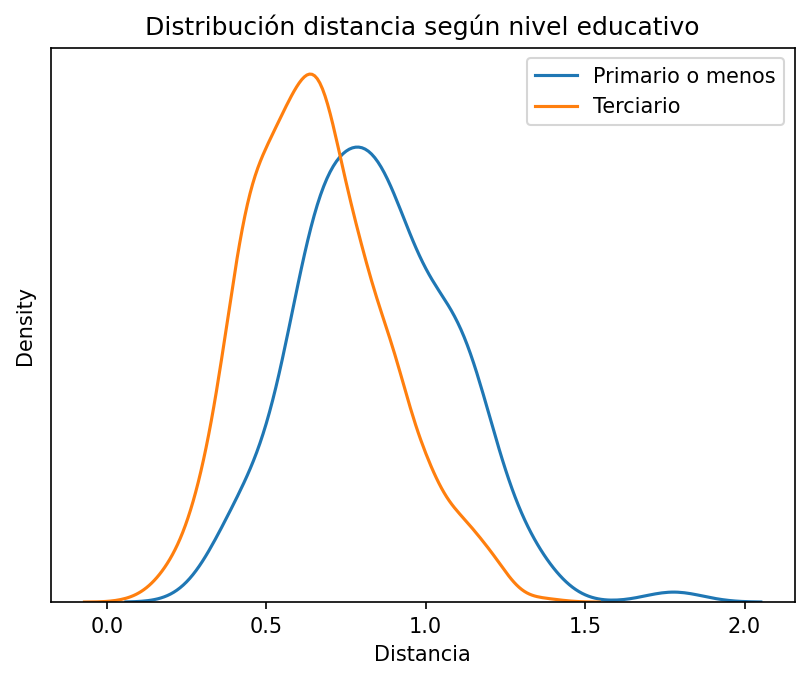

In [39]:
lpop_adulto = lpop[lpop['edr']<=1]
lpop_joven = lpop[lpop['edr']==3]
plt.figure(dpi=150)

sns.kdeplot(
   lpop_adulto[lpop_adulto['gpt_num_preg']>8]['gpt_distance_norm'], label="Primario o menos"
)
sns.kdeplot(
   lpop_joven[lpop_joven['gpt_num_preg']>8]['gpt_distance_norm'], label="Terciario"
)
plt.title("Distribución distancia según nivel educativo")
plt.xlabel("Distancia")
plt.yticks([], [])
plt.legend(loc='upper right')
plt.savefig('educacion_gpt_distancias.png')
plt.show()

In [23]:
reader.value_labels()['conocim_esp']

{1: 'Muy alto', 2: 'Alto', 3: 'Ni alto ni bajo', 4: 'Bajo', 5: 'Muy bajo'}

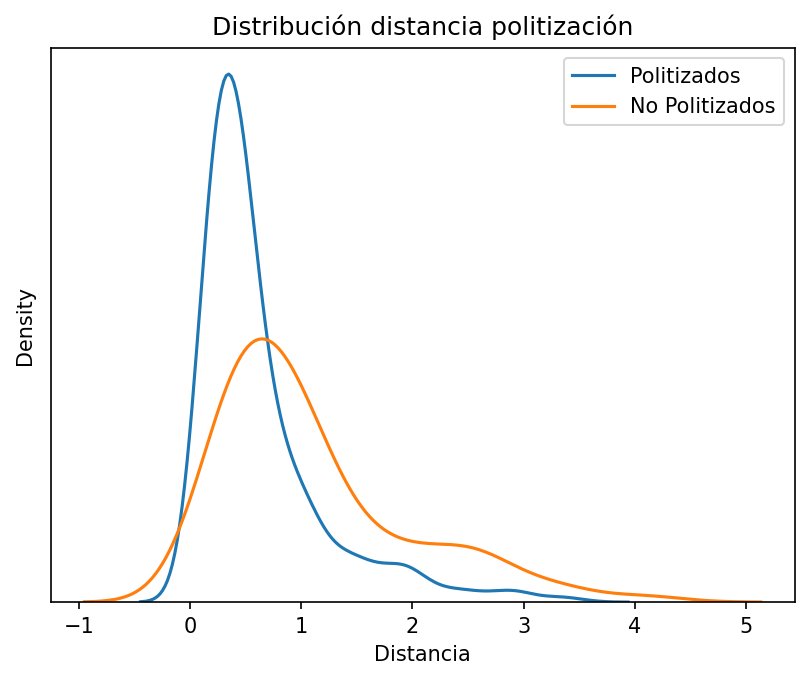

In [38]:
lpop_adulto = lpop[lpop['conocim']<=2]
lpop_joven = lpop[lpop['conocim']>=4]
plt.figure(dpi=150)

sns.kdeplot(
   lpop_adulto[lpop_adulto['gpt_num_preg']>8]['gpt_distance_norm_wt'], label="Politizados"
)
sns.kdeplot(
   lpop_joven[lpop_joven['gpt_num_preg']>8]['gpt_distance_norm_wt'], label="No Politizados"
)
plt.title("Distribución distancia politización")
plt.xlabel("Distancia")
plt.yticks([], [])
plt.legend(loc='upper right')
plt.savefig('politización_gpt_distancias.png')
plt.show()